# fitting absorption spectrum for Rb atoms

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
colnames = ['wavelength', 'inten']
data = pd.read_csv('transmission.txt', sep='\s+')
data.columns = colnames

Let's take a look at the raw data first, plotting only every 100th element

Text(0, 0.5, 'Transmitted Intensity $V$')

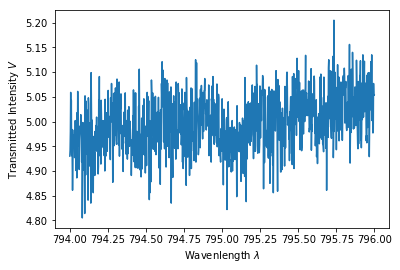

In [3]:
plt.plot(data['wavelength'][::100], data['inten'][::100])

plt.xlabel('Wavenlength $\lambda$')
plt.ylabel('Transmitted Intensity $V$')

Since our rubidium atoms are located within a glass case, we expect to see an interference pattern caused by the effect of the laser light passing through the glass pane. This takes the form of a sinosoidal *standing wave* whose intensity amplitude is proportional to the square of the laser beam's E-field intensity, e.g.
$$ B \propto |E_o|^2 $$
We know $E$ takes a sinosoidal form, so this means that our interference term, in terms of intensity, is:
$$ I_{inter} = 2B\ \text{sin}(2\omega \pi \lambda)) + C $$
We'll define this background term and see what it looks like fitted to the data:

In [4]:
def standing_wave(lamb, B, omega, C):
    return B * (2*np.sin(2*omega*np.pi * (lamb)))**2 + C

In [5]:
popt,cov = curve_fit(standing_wave, data['wavelength'].values, data['inten'].values)

In [6]:
B, omega, C= popt
normed = standing_wave(data['wavelength'].values, B, omega, C)
print('B = ', B, 'omega = ', omega, 'C = ', C)

B =  0.0051658675166784355 omega =  0.9998640830023073 C =  4.982220627972743


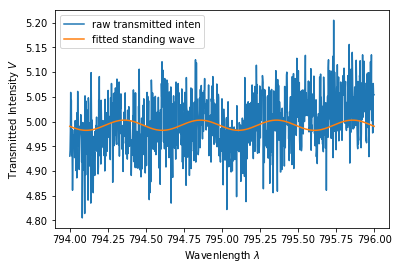

In [10]:
plt.plot(data['wavelength'][::100], data['inten'][::100], label='raw transmitted inten')

plt.xlabel('Wavenlength $\lambda$')
plt.ylabel('Transmitted Intensity $V$')
plt.plot(data['wavelength'].values, normed, label='fitted standing wave')
plt.legend(loc='best')

Now we can take a look at what the absorption line should look like. The absorption line of Rb atoms takes a Lorentzian lineshape given as:
$$ L(\lambda) = \frac{w^2}{((\lambda - \lambda_o)^2 + w^2)} $$

Where $w$ is the line's full-width, half-maximum width (FWHM) and $\lambda_o$ is the absorption, or resonance wavelength. It is easier to think of resonance in terms of a frequency, which can be converted from wavelength as:
$$ \omega_o = \frac{c}{\lambda_o} $$
Where $c$ is the wavespeed, in this case the speed of light.

In [11]:
# define the lorentzian lineshape function
def lorentz(lamb, a, w, lamb_o):
    return a * w**2 / ((lamb - lamb_o)**2 + w**2)

Using values from the literature, our Lorentzian absorption line for Rb (in transmission space) should look something like this:

Text(0, 0.5, 'Transmission Inten')

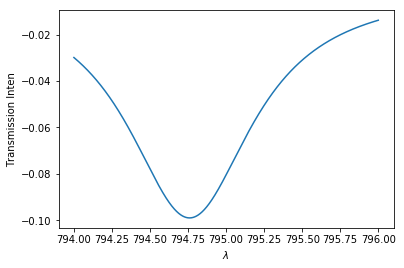

In [60]:
plt.plot(lamb, lorentz(lamb, -0.099, 0.5, 794.76))
plt.xlabel("$\lambda$")
plt.ylabel('Transmission Inten')

In [24]:
# fitting pieces--unpack pandas objects
lamb = data['wavelength'].values
inten_abs = data['inten'].values #- standing_wave(lamb, A, phase, B)

Now that we've fit the background, let's see if we can do a Lorentzian fit to the intensity once the standing wave's been subtracted out. We know that the statistical error in the transmitted intensity is related to the discrete number of photon counts hitting a photodiode. This is a *poissonian* process, so the error associated is related to $\sqrt{N}$ for $N$ counts in each wavelength bin.

What we measure is voltage, but since this is directly proportional to photon counts, we set $\sigma = \sqrt{N_v}$ where $N_v$ is the number of volts in each bin.

In [25]:
lorentz_fit,cov_l = curve_fit(lorentz, lamb, inten_abs - normed, sigma=np.sqrt(data['inten'].values))

In [26]:
a, w, lamb_o = lorentz_fit
print('a = ', a, 'w = ', w, 'lamb_o = ', lamb_o)

a =  -0.018338027386943276 w =  -0.28742894655625695 lamb_o =  794.2607543919838


These values aren't bad, but there's one small issue. $\lambda_o$ is *known* to be 794.76 nm in Rb. So our inference is off, likely due to noise and the fact that there is a slight positive slope to the raw data, due to the slight increase in intensity as wavelength is lengthened in the laser.

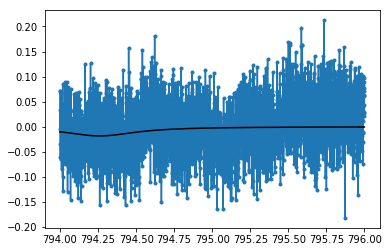

In [27]:
plt.plot(lamb[::30], inten_abs[::30] - normed[::30], marker='.')#, yerr=np.sqrt(inten_abs[::1000]))
#plt.plot(data['wavelength'].values, fit_fn(data['wavelength'].values, A, w, lamb_o, m, B, C), color='k')
plt.plot(lamb, lorentz(lamb, a, w, lamb_o), color='k')

What we're going to do now is define a full fitting function, taking into account both sinosoidal and linear noise elements to the intensity. To do this fit, we're first going to "freeze" $lambda_o$ at its true value and fit the rest of the parameters. This is so that the center of the Lorentzian doesn't get "lost" due to the large sinosoidal noise contribution.

In [28]:
def fit_fn(lamb, a, w, m, B, C):
    lamb_o = 794.76
    
    #B = 0.005165867516678435
    #C = 4.982220627972743
    omega = 0.999864083002307
    #m = 1.87951987e-02
    lorentz = w**2 / ((lamb - lamb_o)**2 + w**2)
    return C + a * lorentz + (B*np.sin(2*np.pi*omega*lamb))**2 + m*lamb

In [30]:
p0 = [-1, 0.2, 0.01, 0.1, 5] # set up an initial guess vector
fullfit, cov_fit = curve_fit(fit_fn, lamb, inten_abs, p0=p0, sigma=np.sqrt(data['inten'].values))

In [44]:
a, w, m, B, C = fullfit
names = ['a', 'w', 'm', 'B', 'C']
for i in range(len(fullfit)):
    print(names[i], ' = ', fullfit[i], '+/-', np.sqrt(np.diag(cov_fit))[i])

a  =  -0.09906616840699536 +/- 0.018202868090208428
w  =  1.8481373492371413 +/- 0.22206297144391998
m  =  0.016710379841870602 +/- 0.00039383974048082146
B  =  0.1146784032071374 +/- 0.002078381248510402
C  =  -8.209489195307704 +/- 0.3194552231363066


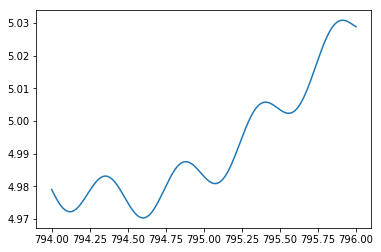

In [45]:
#plt.plot(lamb, inten_abs)
plt.plot(lamb, fit_fn(lamb, a, w, m, B, C) )

Now that we've fit everything *but* $\lambda_o$, we can now free it up and see where the peak lies within the data. To do this, we define a new fit function with everything but the absorption wavelength frozen.

In [46]:
def fit_fn2(lamb, lamb_o):
        
    a = -0.09906219
    w = 1.84808828
    m = 0.0167104
    B = 0.11467851
    C = -8.2094892
    omega = 0.999864083002307
    #m = 1.87951987e-02
    lorentz = w**2 / ((lamb - lamb_o)**2 + w**2)
    return C + a * lorentz + (B*np.sin(2*np.pi*omega*lamb))**2 + m*lamb

In [51]:
p0 = [794.0]  # initial guess
lambfit, cov_lamb = curve_fit(fit_fn2, lamb, inten_abs, p0=p0, sigma=np.sqrt(data['inten'].values))

In [56]:
lamb_o = lambfit[0]
print('lamb_o = ', lamb_o, ' +/- ', np.sqrt(np.diag(cov_lamb))[0])

lamb_o =  794.7748556785666  +/-  0.006524683296030238


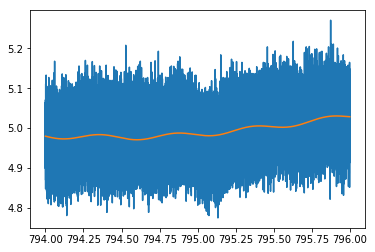

In [57]:
plt.plot(lamb, inten_abs)
plt.plot(lamb, fit_fn2(lamb, lamb_o))


So we've gotten our fit pretty close to the accepted value! 